# Testing saddle point problems in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

First create a grid and a Laplacian operator on it

In [3]:
nx = 130; ny = 130;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [4]:
L = plan_laplacian(size(w),with_inverse=true)
L⁻¹(w::T) where {T} = L\w

L⁻¹ (generic function with 1 method)

Now create a shape, with discrete points and associated regularization and interpolation operator

In [5]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ[1:n])
yb = 1.0 + R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [6]:
E = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)
#Ẽ = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true,filter=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

In [7]:
PS = SaddleSystem((w,f),(x->L\x,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,130,130}
   Force of type Whirl.Fields.ScalarData{128}


  0.028271 seconds (467 allocations: 1.358 MiB)


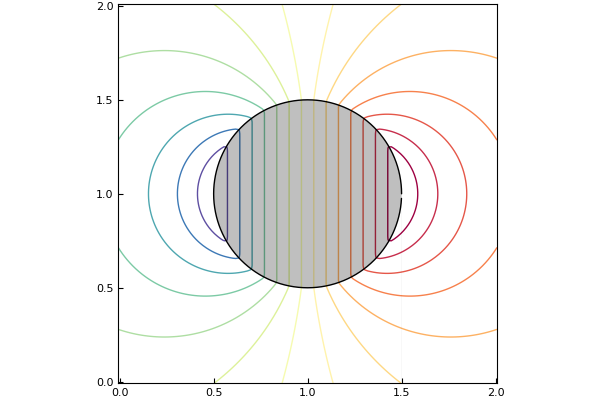

/Users/jeff/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [8]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb-1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = PS\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [9]:
fex = -2*cos.(θ[1:n]);
norm(f./ds-fex,Inf)

0.03528802363993222

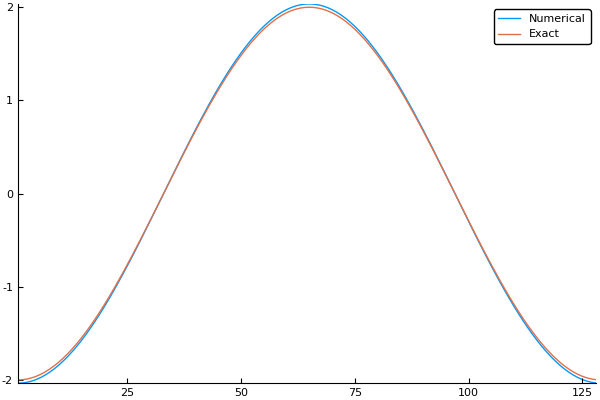

In [10]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

Test with the integrating factor as the operator, rather than Laplacian

In [11]:
Δt = 1.0
#H!(v,u) = A_mul_B!(v,plan_intfact(Δt,u),u)
H(u) = plan_intfact(Δt,u)*u
HS = SaddleSystem((w,f),(plan_intfact(Δt,w),Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,130,130}
   Force of type Whirl.Fields.ScalarData{128}
